# Transformers Benchmarks - Exercises

This notebook is an exercise for the Transformers Benchmarks Project. 
https://github.com/mli/transformers-benchmarks

## Setup

First check environment and all available GPUs.

In [1]:
import torch

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

# check apex，Megatron-LM depends on it
!pip list|grep apex
# ninja builder
!ninja --version

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pytorch version	: 1.13.0a0+08820cb
CUDA version	: 11.7
GPU0		: NVIDIA GeForce RTX 3090
GPU1		: NVIDIA GeForce RTX 3090
apex                          0.1
1.11.0


Next install packages we need beyond pytorch. Note that both deepspeed and megatron-lm need `nvcc` to build custom operators. Make sure you have a complete CUDA installation rather than just runtime. 

In [35]:
from IPython.display import clear_output

# !git clone https://github.com/huggingface/transformers
# !git clone https://github.com/NVIDIA/Megatron-LM
!git clone https://github.com/microsoft/Megatron-DeepSpeed
!cd transformers; pip install .
%pip install datasets evaluate accelerate deepspeed psutil
%pip install pydantic --upgrade

clear_output()

Cloning into 'Megatron-DeepSpeed'...
fatal: unable to access 'https://github.com/microsoft/Megatron-DeepSpeed/': GnuTLS recv error (-110): The TLS connection was non-properly terminated.


## Experiment 

The `Exp4Exercise` class stores both hyperparameters and performance results for one experiment. 

In [127]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp4Exercise:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    pipeline_mp_size: int = 1# Pipeline parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config 
    offload: bool = False    # Zero-offload to cpu
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = f'deepspeed --num_nodes 1 --num_gpus {self.num_gpus}'     
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

In [30]:
def megatron_gpt4exercise(exp):
    global_batch_size = exp.batch_size * exp.num_gpus * exp.grad_accum / exp.tensor_para
    cmd = f'''{exp.launcher} Megatron-LM/pretrain_gpt.py \
--num-layers {exp.num_layers} --hidden-size {exp.hidden_size} \
--num-attention-heads {exp.num_heads} \
--tensor-model-parallel-size {exp.tensor_para} \
--pipeline-model-parallel-size {exp.pipeline_mp_size} \
--micro-batch-size {exp.batch_size} --global-batch-size {int(global_batch_size)} \
--seq-length {exp.seq_len} --max-position-embeddings {exp.seq_len} \
--train-iters {exp.steps} --data-path gpt2-sample_text_document \
--vocab-file gpt2-vocab.json --merge-file gpt2-merges.txt \
--timing-log-level 2 \
--timing-log-option max \
--data-impl mmap --lr 0.00015 --log-interval 5 '''
    cmd += '--bf16 ' if exp.bf16 else ''
    cmd += '--fp16 ' if exp.fp16 else ''
    cmd = "CUDA_DEVICE_MAX_CONNECTIONS=1 " + cmd
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return megatron_log(exp, 'log.txt') 


def megatron_log(exp, log_filename):
    with open(log_filename) as f:
        text = f.read()
    # Find the last number after the key, returns 0 if not exists
    query = lambda key: float(next(iter(        
        reversed(re.findall(key+': +([\d\.]+)', text))), 0))
    query2 = lambda key: float(next(iter(        
        reversed(re.findall(key+'.*:\s(\d+.\d+)', text))), 0))
    if 'CUDA out of memory' in text:
        print('Out of GPU memory, try a smaller batch size')
        return
    iter_time = query('elapsed time per iteration \(ms\)')
    if iter_time == 0:
        print(f'Failed. Check "{log_filename}" to find error')
        return
    exp.samples_per_sec = query('global batch size') / iter_time * 1e3
    exp.gpu_mem = query('max allocated')/1e3
    print('Time breakdown\t\t: forward+backward %.2f, communication %.2f, optimizer %.2f' %(
        (query2('forward-compute')+query2('backward-compute')) / iter_time, 
        query2(' grads-all-reduce') / iter_time, query2('optimizer') / iter_time))        
    return exp

The following function visualize results among different experiments. 

In [5]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])
    plt.show()

Downloads data for Megatron

In [44]:
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt    
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/gpt2-sample_text_document.bin
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/gpt2-sample_text_document.idx
    
clear_output()

## Exercise start

#### 1. Evaluate this notebook on your GPU machines. You may need to tune the batch size to fit into your memory.

In [7]:
dp_gpt2 = megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs", "gpt2-medium", 5, bf16=True, gpus='0,1'))

Time breakdown		: forward+backward 0.56, communication 0.38, optimizer 0.05


#### 2. Try to use a smaller batch size, check how it affect TFLOPS.

Time breakdown		: forward+backward 0.45, communication 0.48, optimizer 0.06
Time breakdown		: forward+backward 0.52, communication 0.41, optimizer 0.06
Time breakdown		: forward+backward 0.57, communication 0.37, optimizer 0.05


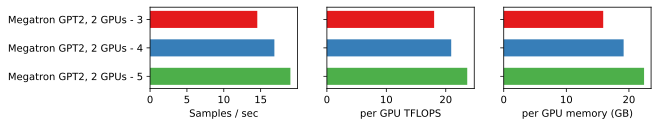

In [8]:
dp_gpt2_exps = []
for batch_size in [3, 4, 5]:
    dp_gpt2 = megatron_gpt4exercise(Exp4Exercise(
        f"Megatron GPT2, 2 GPUs - {batch_size}", "gpt2-medium", 
        batch_size, bf16=True, gpus='0,1'))
    dp_gpt2_exps.append(dp_gpt2)
compare(dp_gpt2_exps)

答：数据并行场景下，batch size越大（前提是能放进模型），模型吞吐量越大，TFLOPS越大

#### 3. Try to use pipeline parallelism in Megatron.

数据并行分割数据，张量并行tensor parallelism (TP)分割参数. 为了方便数据并行、张量并行和流水线并行，三者比较，这里先跑一下张量并行

Time breakdown		: forward+backward 0.95, communication 0.00, optimizer 0.04


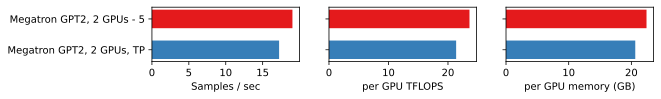

In [12]:
tp_gpt2 = megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs, TP", "gpt2-medium", 10, bf16=True, gpus='0,1', tensor_para=2))
compare([dp_gpt2, tp_gpt2])

Time breakdown		: forward+backward 0.66, communication 0.00, optimizer 0.02


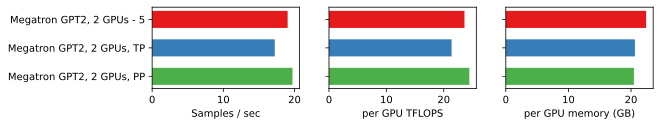

In [16]:
pp_gpt2 = megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs, PP", "gpt2-medium", 6, bf16=True, gpus='0,1', pipeline_mp_size=2))
compare([dp_gpt2, tp_gpt2, pp_gpt2])

答：从以下几个角度看下实验结果
1. 吞吐量和TFLOS：数据并行 > 流水线并行 > 张量并行
2. batch size：张量并行(10) > 流水线并行(6) > 数据并行(5) 

#### 4. Try to use deepspeed with Megatron

In [128]:
def ds_megatron_gpt4exercise(exp):
    global_batch_size = exp.batch_size * exp.num_gpus * exp.grad_accum / exp.tensor_para
    cmd = f'''{exp.launcher} Megatron-DeepSpeed/pretrain_gpt.py \
--num-layers {exp.num_layers} --hidden-size {exp.hidden_size} \
--num-attention-heads {exp.num_heads} \
--tensor-model-parallel-size {exp.tensor_para} \
--pipeline-model-parallel-size {exp.pipeline_mp_size} \
--no-pipeline-parallel \
--micro-batch-size {exp.batch_size} --global-batch-size {int(global_batch_size)} \
--seq-length {exp.seq_len} --max-position-embeddings {exp.seq_len} \
--train-iters {exp.steps} --data-path gpt2-sample_text_document \
--vocab-file gpt2-vocab.json --merge-file gpt2-merges.txt \
--deepspeed --deepspeed_config {exp.ds_config} \
--data-impl mmap --lr 0.00015 --log-interval 5 '''
    cmd += '--bf16 ' if exp.bf16 else ''
    cmd += '--fp16 ' if exp.fp16 else ''
    cmd += '--checkpoint-activations ' if exp.grad_ckpt else ''
    cmd += '--cpu-optimizer ' if exp.offload else ''
    cmd = "CUDA_DEVICE_MAX_CONNECTIONS=1 " + cmd
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return megatron_log(exp, 'log.txt') 

Test Deepspeed with zero-1 first. An import equation here:

`train_batch_size = train_micro_batch_size_per_gpu * gradient_accumulation * number of GPUs.`

In [56]:
ds_zero1_config = {
  "train_batch_size": 12,
  "gradient_accumulation_steps": 1,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 1
  }
}
json.dump(ds_zero1_config, open("ds_zero1_config.json", "w"), indent=4)

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.68


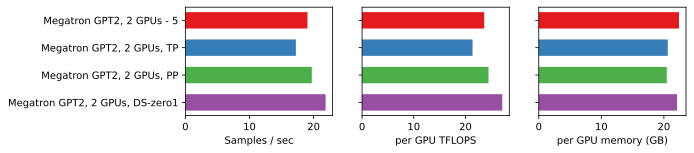

In [57]:
ds_zero1_gpt2 = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs, DS-zero1", "gpt2-medium", 6, bf16=True, 
    deepspeed=True, ds_config='ds_zero1_config.json', 
    gpus='0,1'))
compare([dp_gpt2, tp_gpt2, pp_gpt2, ds_zero1_gpt2])

DeepSpeed Zero-2 Go Go Go!

In [68]:
ds_zero2_config = {
  "train_batch_size": 12,
  "gradient_accumulation_steps": 1,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 2
  }
}
json.dump(ds_zero2_config, open("ds_zero2_config.json", "w"), indent=4)

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


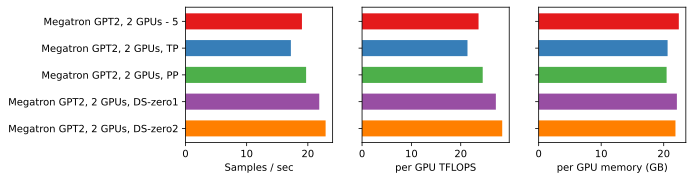

In [64]:
ds_zero2_gpt2 = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs, DS-zero2", "gpt2-medium", 6, bf16=True, 
    deepspeed=True, ds_config='ds_zero2_config.json', 
    gpus='0,1'))
compare([dp_gpt2, tp_gpt2, pp_gpt2, ds_zero1_gpt2, ds_zero2_gpt2])

DeepSpeed Zero-2 with tensor parallelism

Please note that there is no data parallel in the tensor paralleml setting, so the global batch size is equal to micro batch size for each GPU

In [86]:
ds_zero2_tp_config = {
  "train_batch_size": 11,
  "gradient_accumulation_steps": 1,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 2
  }
}
json.dump(ds_zero2_tp_config, open("ds_zero2_tp_config.json", "w"), indent=4)

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


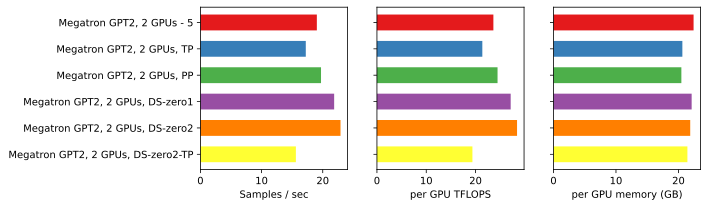

In [87]:
ds_zero2_tp_gpt2 = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT2, 2 GPUs, DS-zero2-TP", "gpt2-medium", 11, bf16=True, 
    deepspeed=True, ds_config='ds_zero2_tp_config.json', tensor_para=2,
    gpus='0,1'))
compare([dp_gpt2, tp_gpt2, pp_gpt2, ds_zero1_gpt2, ds_zero2_gpt2, ds_zero2_tp_gpt2])

答：
1. 没有引入张量并行(TP)前，Zero-1和Zero-2都可以显著提高模型的吞吐量和TFLOPS
2. 张量并行的引入，使batch size从6提升到11，但是由于没有数据并行，实际上的全局batch size只有11，小于数据并行的12。
3. 张量并行的引入，使得吞吐量和TFLOPS都显著降低，并不只是全局batch size从12降低到11的影响

#### 5. Try to use DP with gradient checkpoint for `GPT-Neo-1.3B`

DP without Zero will be out of GPU memory, so use DP with Zero-2

In [103]:
ds_neo_zero2_config = {
  "train_batch_size": 32,
  "gradient_accumulation_steps": 4,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 2
  }
}
json.dump(ds_neo_zero2_config, open("ds_neo_zero2_config.json", "w"), indent=4)

In [96]:
tp_gpt_neo_accum = megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT-Neo-1.3B, 2 GPUs, TP\ngrad_accum=4", "EleutherAI/gpt-neo-1.3B", 1, bf16=True, gpus='0,1',
    tensor_para=2, grad_accum=4, steps=10))

Time breakdown		: forward+backward 0.95, communication 0.01, optimizer 0.04


Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


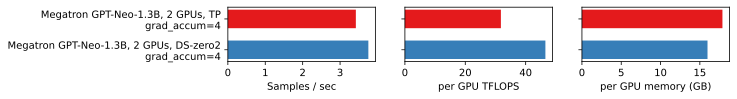

In [104]:
ds_zero2_neo_accm = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT-Neo-1.3B, 2 GPUs, DS-zero2\ngrad_accum=4", "EleutherAI/gpt-neo-1.3B", 4, bf16=True, 
    grad_accum=4, steps=5, deepspeed=True, ds_config='ds_neo_zero2_config.json', grad_ckpt=True,
    gpus='0,1'))
compare([tp_gpt_neo_accum, ds_zero2_neo_accm])

答：
1. 根据沐神的视频里的结论，13亿参数的neo-gpt可以使用张量并行训练。这里作为对照组
2. 数据并行，13亿参数无法放入24GB的GPU。使用Zero-2之后也不行，需要打开grad checkpoint后才能放入GPU
3. DP+Zero-2+grad checkpoint 吞吐量略好于张量并行，TFLOPS高很多，但不少都被grad checkpoint浪费了

#### 6. Try to benchmark T5, which has both encoder and decoder.

In [ ]:
# not interesting
pass

#### 7. Try the largest model in you ran in your machine.

##### TP+Zero-2+grad checkpoint

In [119]:
ds_neo27_zero2_config = {
  "train_batch_size": 1,
  "gradient_accumulation_steps": 1,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 2
  }
}
json.dump(ds_neo27_zero2_config, open("ds_neo27_zero2_config.json", "w"), indent=4)

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


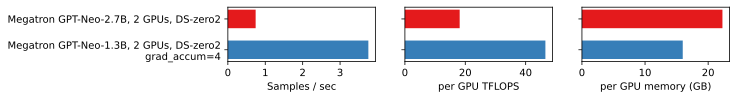

In [120]:
ds_zero2_neo27_tp = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT-Neo-2.7B, 2 GPUs, DS-zero2", "EleutherAI/gpt-neo-2.7B", 1, fp16=True, 
    grad_accum=1, steps=5, deepspeed=True, ds_config='ds_neo27_zero2_config.json', tensor_para=2, grad_ckpt=True,
    gpus='0,1'))
compare([ds_zero2_neo27_tp, ds_zero2_neo_accm])

答: 
1. TP+Zero-2+grad checkpoint最大可以放入27亿参数的neo-gpt。
可不可以再厉害点？

##### zero-offload

In [140]:
ds_zero2_offload_config = {
  "train_batch_size": 1,
  "gradient_accumulation_steps": 1,
  "optimizer": {
    "type": "Adam",
    "params": {
      "lr": 0.00015
    }
  },
  "fp16": {
    "enabled": True
  },
  "zero_optimization": {
    "stage": 2,
    "offload_optimizer": {
        "device": "cpu"
    },
    "contiguous_gradients": True,
    "overlap_comm": True
  }
}
json.dump(ds_zero2_offload_config, open("ds_zero2_offload_config.json", "w"), indent=4)

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


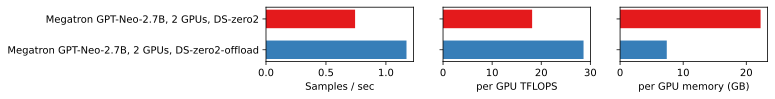

In [131]:
ds_zero2_offload_tp = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT-Neo-2.7B, 2 GPUs, DS-zero2-offload", "EleutherAI/gpt-neo-2.7B", 4, fp16=True, 
    grad_accum=1, steps=5, deepspeed=True, ds_config='ds_zero2_offload_config.json', tensor_para=2, grad_ckpt=True,
    offload=True, gpus='0,1'))
compare([ds_zero2_neo27_tp, ds_zero2_offload_tp])

答：

2. 用Zero-offload把模型参数offload到内存，轻松就可以放入27亿参数的模型，用的GPU显存还不到10g，同时吞吐量和TFLOPS都有提升。可不可以再厉害点？

Time breakdown		: forward+backward 0.00, communication 0.00, optimizer 0.00


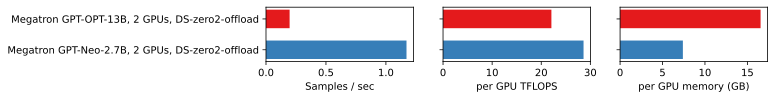

In [134]:
ds_zero2_offload_opt13b_tp = ds_megatron_gpt4exercise(Exp4Exercise(
    "Megatron GPT-OPT-13B, 2 GPUs, DS-zero2-offload", "facebook/opt-13b", 1, bf16=True, 
    grad_accum=1, steps=5, deepspeed=True, ds_config='ds_zero2_offload_config.json', tensor_para=2, grad_ckpt=True,
    offload=True, gpus='0,1'))
compare([ds_zero2_offload_opt13b_tp, ds_zero2_offload_tp])

答：

3. 用Zero-offload，130亿参数的OPT模型成功放入！百亿模型成就达成！

#### 8. Estimate the time you need to train `gpt2-medium` on 1 billion tokens.

In [149]:
tokens = 1000000000
seq_len = 1024
num_sample = tokens // seq_len
best_throughput = 24 # samples / second
time_to_train = num_sample / best_throughput
print(f"num of samples: {num_sample}, time to train(h): {time_to_train/3600}")

num of samples: 976562, time to train(h): 11.302800925925927


答：10亿token，按照1024的输入长度计算，差不多是100万样本，按照3090最好的吞吐量24个样本每秒，差不多需要11个小时。
一点思考，现在数据集动辄上亿，就以`laion-400m`估计，有4亿个样本，那就需要4000小时，差不多是166天，半年时间训练一个epoch，完全无法承受的时间代价。
